In [1]:
from newsapi import  NewsApiClient
from datetime import date, timedelta

In [12]:
query = 'Tesla'
newsapi = NewsApiClient(api_key='96cbb30a07ed4709a37a140a2c2eca6b')
time_period = date.today() - timedelta(days = 7)
print(time_period)
articles = newsapi.get_everything(q=query,
                                  from_param='2022-01-01',
                                  to='2022-03-30',
                                  language = 'en',
                                  sort_by = 'relevancy',
                                  page_size = 100)

print(len(articles['articles']))

for article in articles['articles']:
    print(article['title'] + " | " + article['publishedAt'] + " | " + article['url'])

2023-12-13


NewsAPIException: {'status': 'error', 'code': 'parameterInvalid', 'message': 'You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2023-11-19, but you have requested 2022-01-01. You may need to upgrade to a paid plan.'}

___

In [24]:
import requests

api = "https://api.polygon.io/v2/reference/news?ticker=TSLA&published_utc.gte=2022-01-01&published_utc.lt=2022-03-31&limit=1000&apiKey=lvc9K2gyfzuBKSpAFBIcQpj1T4nRFB6k"

try:
    response = requests.get(api)
    json_response = response.json()
    
    articles = json_response['results']
    # Keep articles from publisher 'Reuters'
    #articles = [article for article in articles if article['publisher']['name'] == 'NYTimes']
    # Get unique list of publisher names
    publisher_names = set([article['publisher']['name'] for article in articles])
except:
    print("Error")

print(len(articles))
#display(articles)
print(publisher_names)

1000
{'Seeking Alpha', 'PennyStocks', 'Investing.com', 'Zacks Investment Research', 'Quartz', 'Invezz', 'MarketWatch', 'The Motley Fool', 'Benzinga'}


In [114]:
import sys
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from newsapi import NewsApiClient
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

#nltk.download('vader_lexicon')

pd.set_option('display.max_colwidth',1000)

SIA = SentimentIntensityAnalyzer()

In [115]:
# Retrieves a list of news sources based on the specified category.
def get_sources(category = None):
  newsapi = NewsApiClient(api_key='api_key')
  sources = newsapi.get_sources()
  
  if category is not None:
    result = [source['id'] for source in sources['sources'] if source['category'] == category and source['language'] == 'en']
  else:
    result = [source['id'] for source in sources['sources'] if source['language'] == 'en']
  
  return result

len(get_sources())  

81

In [116]:
#Get the list of the business news sources

get_sources('business')

['australian-financial-review',
 'bloomberg',
 'business-insider',
 'business-insider-uk',
 'financial-post',
 'fortune',
 'the-wall-street-journal']

In [117]:
time_period = (date.today() - timedelta(days = 30)).isoformat()

time_object = datetime.strptime(time_period, '%Y-%m-%d')

time_period = time_object.strftime('%d-%b-%Y')

print(time_period)

17-Jun-2023


In [122]:
def get_articles_sentiments(keywrd, startd, sources_list=None, show_all_articles=False):
    newsapi = NewsApiClient(api_key='api_key')

    if type(startd) == str:
        my_date = datetime.strptime(startd, '%d-%b-%Y')
    else:
        my_date = startd

    if sources_list:
        articles = newsapi.get_everything(
            q=keywrd, from_param=my_date.isoformat(), to=(my_date + timedelta(days=30)).isoformat(),
            language="en", sources=",".join(sources_list), sort_by="relevancy", page_size=100
        )
    else:
        articles = newsapi.get_everything(
            q=keywrd, from_param=my_date.isoformat(), to=(my_date + timedelta(days=30)).isoformat(),
            language="en", sort_by="relevancy", page_size=100
        )

    article_content = ''
    date_sentiments = {}
    date_sentiments_list = []
    seen = set()

    for article in articles['articles']:
        if str(article['title']) in seen:
            continue
        else:
            seen.add(str(article['title']))

        article_content = str(article['title']) + '. ' + str(article['description'])
        sentiment = SIA.polarity_scores(article_content)['compound']

        date_sentiments.setdefault(my_date, []).append(sentiment)
        date_sentiments_list.append((sentiment, article['url'], article['title'], article['description']))

    date_sentiments_l = sorted(date_sentiments_list, key=lambda tup: tup[0], reverse=True)
    sent_list = list(date_sentiments.values())[0]

    return pd.DataFrame(date_sentiments_list, columns=['Sentiment', 'URL', 'Title', 'Description'])


0.219212
100
0         Nvidia's stellar rally so far has dominated the US stock market, but the company's stock price is overvalued even considering its bright future.
1                                               Insider's Phil Rosen breaks down the central bank chairman's testimony and how the stock market responded.
2                                                 Even a shallow recession could wreak havoc on stock prices, "Dr. Doom" economist Nouriel Roubini warned.
3     Morgan Stanley's Adam Jonas slashed his Tesla rating Thursday, warning earnings could fall as Elon Musk's EV maker presses ahead with its price war.
4     Fundstrat expects low inflation readings to continue throughout the summer, which would embolden investors who expect a soft landing in the economy.
                                                                              ...                                                                         
95        "We reckon that the excess liquid assets held b

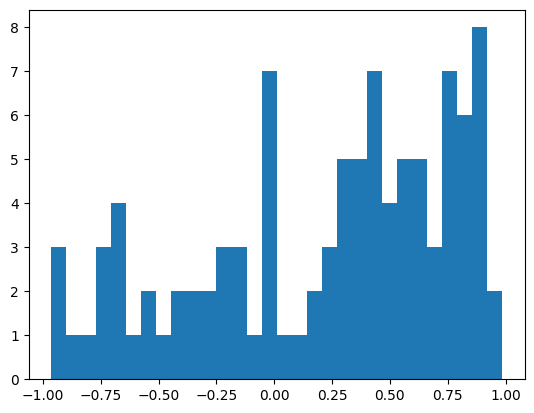

In [119]:
sources = get_sources('business')
return_articles = get_articles_sentiments('stock',time_period,sources_list = sources, show_all_articles = True)
return_articles.Sentiment.hist(bins = 30, grid = False)

print(return_articles.Sentiment.mean())

print(return_articles.Sentiment.count())

print(return_articles.Description)

In [121]:
return_articles.sort_values(by='Sentiment', ascending=True)[['Sentiment','URL']].head(2)

,Sentiment,URL
80,-0.9643,https://markets.businessinsider.com/news/stocks/jeremy-grantham-gmo-superbubble-ai-stocks-housing-market-bubble-crash-2023-7
2,-0.9393,https://markets.businessinsider.com/news/stocks/nouriel-roubini-economy-recession-tropical-storm-financial-crisis-dr-doom-2023-6


In [18]:
from datetime import datetime
import requests

TICKER = 'AMZN'
API_KEY = '0JV1305HSHHJ3MNH'

# Convert time_from and time_to to the desired format
time_from = "time_from=20220101T0000" #datetime.strptime("2022-01-01", "%Y-%m-%d").strftime("%Y%m%dT%H%M")
time_to = "time_to=20220331T2359" #datetime.strptime("2022-03-31", "%Y-%m-%d").strftime("%Y%m%dT%H%M")
limit = "limit=1000"
sort = "sort=LATEST"

api = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={TICKER}&{time_from}&{time_to}&{sort}&{limit}&apikey={API_KEY}'

try:
    response = requests.get(api)
    json_response = response.json()
    
    articles = json_response['feed']
    print(len(articles))
    display(articles)
    # Keep articles from publisher 'Reuters'
    #articles = [article for article in articles if article['publisher']['name'] == 'NYTimes']
    # Get unique list of publisher names
    
except Exception as e:
    print(e)


707


[{'title': "34 Public Companies That Made Time's 100 Most Influential For 2022: AMC, Disney, Ford And More",
  'url': 'https://www.benzinga.com/node/26413667',
  'time_published': '20220331T232127',
  'authors': [],
  'summary': "Time announced this week its annual 100 Most Influential Companies list. Here's a look at the publicly traded companies that made the list.\nWhat Happened: The 2022 winners were divided into five categories with the Titans category containing the most publicly traded companies of the five groups.\nMan",
  'banner_image': 'https://cdn.benzinga.com/files/imagecache/story_image_685x375C/images/story/2012/screen_shot_2022-03-31_at_7.19.03_pm.png',
  'source': 'Benzinga',
  'category_within_source': 'General',
  'source_domain': 'www.benzinga.com',
  'topics': [{'topic': 'Life Sciences', 'relevance_score': '0.142857'},
   {'topic': 'Energy & Transportation', 'relevance_score': '0.142857'},
   {'topic': 'Technology', 'relevance_score': '0.142857'},
   {'topic': 'Fin

In [9]:
import pandas as pd
from datetime import datetime

# Get news volume for each day
def get_news_volume(articles, quotes) -> dict:
    news_volume = {}
    for article in articles:
        date_str = article['time_published'].split("T")[0]
        date = pd.Timestamp(datetime.strptime(date_str, '%Y%m%d').date())
        if date in news_volume:
            news_volume[date] += 1
        else:
            news_volume[date] = 1
        # Make sure that a bin exists for each day we have price data
    for date in quotes.index:
        news_volume[date] = news_volume[date] if date in news_volume else 0

    news_volume = dict(sorted(news_volume.items()))
    
    return news_volume
    

20220101T0000
20220331T0000
